In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Monte Carlo GBM — Multi-Asset Extension (Correlated)

Goal:
- Extend the single-asset GBM simulator to **multiple assets**
- Introduce **correlations** between assets
- Preserve clean architecture and scalability

This notebook builds a *multi-asset Monte Carlo engine* that produces
correlated price paths using a correlation matrix.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [4]:
# Time parameters
T = 1.0  # years
trading_days = 252
hours_per_day = 6.5
N = int(trading_days * hours_per_day)
dt = T / N

# Monte Carlo
M = 10_000  # number of paths

# Number of assets
n_assets = 3

In [5]:
S0 = np.array([100.0, 80.0, 120.0])
mu = np.array([0.08, 0.05, 0.10])
sigma = np.array([0.20, 0.15, 0.25])

In [6]:
corr_matrix = np.array([
    [1.0, 0.6, 0.3],
    [0.6, 1.0, 0.4],
    [0.3, 0.4, 1.0]
])

In [7]:
#Cholesky Decomposition
L = np.linalg.cholesky(corr_matrix)

In [8]:
def simulate_multi_asset_gbm(S0, mu, sigma, T, N, M, L):
    dt = T / N
    n_assets = len(S0)

    # Independent standard normals
    Z = np.random.normal(0, 1, size=(M, N, n_assets))

    # Correlate them
    Z_corr = Z @ L.T

    # Drift + diffusion terms
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z_corr

    # Log returns
    log_returns = drift + diffusion
    log_paths = np.cumsum(log_returns, axis=1)

    # Insert initial state
    log_paths = np.concatenate(
        [np.zeros((M, 1, n_assets)), log_paths],
        axis=1
    )

    # Price paths
    paths = S0 * np.exp(log_paths)
    return paths

In [9]:
paths = simulate_multi_asset_gbm(
    S0=S0,
    mu=mu,
    sigma=sigma,
    T=T,
    N=N,
    M=M,
    L=L
)

paths.shape

(10000, 1639, 3)

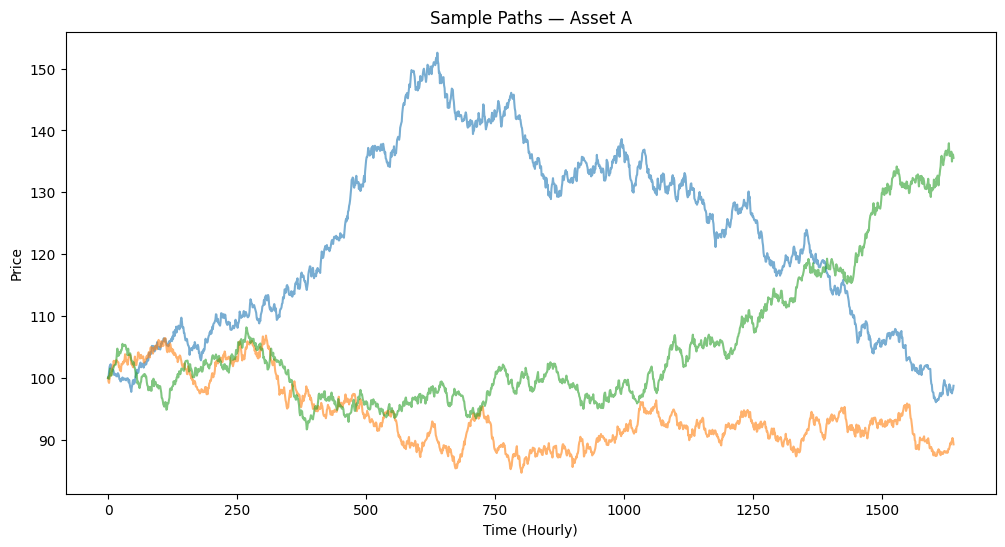

In [10]:
asset_names = ["Asset A", "Asset B", "Asset C"]

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(paths[i, :, 0], alpha=0.6)
plt.title("Sample Paths — Asset A")
plt.xlabel("Time (Hourly)")
plt.ylabel("Price")
plt.show()

In [11]:
log_returns = np.diff(np.log(paths), axis=1)
flat_returns = log_returns.reshape(-1, n_assets)

np.corrcoef(flat_returns.T)

array([[1.        , 0.59996381, 0.29950841],
       [0.59996381, 1.        , 0.39958216],
       [0.29950841, 0.39958216, 1.        ]])